In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc

2025-05-30 08:22:10.040835: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748593330.342455      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748593330.410292      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# For inline plots in Jupyter Notebook
%matplotlib inline

In [3]:
# Load & Clean Data
df = pd.read_csv('/kaggle/input/dataset1/D1.csv')
if 'Unnamed: 0' in df.columns:
    df.drop('Unnamed: 0', axis=1, inplace=True)

df.dropna(subset=['statement', 'status'], inplace=True)
df.drop_duplicates(inplace=True)
df = df.reset_index(drop=True)
print("Data shape after cleaning:", df.shape)
print(df['status'].value_counts())


Data shape after cleaning: (51093, 2)
status
Normal                  16040
Depression              15094
Suicidal                10644
Anxiety                  3623
Bipolar                  2501
Stress                   2296
Personality disorder      895
Name: count, dtype: int64


In [4]:
# Balance Classes by Resampling
def resample_data(df):
    max_count = df['status'].value_counts().max()
    df_resampled = pd.DataFrame()
    for status in df['status'].unique():
        df_class = df[df['status'] == status]
        if len(df_class) < max_count:
            df_class_resampled = resample(df_class, replace=True, n_samples=max_count, random_state=42)
            df_resampled = pd.concat([df_resampled, df_class_resampled])
        else:
            df_resampled = pd.concat([df_resampled, df_class])
    return df_resampled

df = resample_data(df)
print("After resampling:")
print(df['status'].value_counts())

After resampling:
status
Anxiety                 16040
Normal                  16040
Depression              16040
Suicidal                16040
Stress                  16040
Bipolar                 16040
Personality disorder    16040
Name: count, dtype: int64


In [8]:
# Encode Labels
label_map = {
    'Anxiety': 0,
    'Normal': 1,
    'Depression': 2,
    'Suicidal': 3,
    'Stress': 4,
    'Bipolar': 5,
    'Personality disorder': 6,
}
df['status_label'] = df['status'].map(label_map)

In [9]:
# Tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 128

input_ids = np.zeros((len(df), MAX_LEN), dtype='int32')
attention_masks = np.zeros((len(df), MAX_LEN), dtype='int32')

def generate_bert_inputs(df, input_ids, attention_masks, tokenizer):
    for i, text in tqdm.tqdm(enumerate(df['statement']), total=len(df)):
        tokenized = tokenizer.encode_plus(
            text,
            max_length=MAX_LEN,
            truncation=True,
            padding='max_length',
            add_special_tokens=True,
            return_tensors='np'
        )
        input_ids[i, :] = tokenized['input_ids']
        attention_masks[i, :] = tokenized['attention_mask']
    return input_ids, attention_masks

input_ids, attention_masks = generate_bert_inputs(df, input_ids, attention_masks, tokenizer)


100%|██████████| 112280/112280 [03:53<00:00, 480.84it/s]


In [10]:
#One-Hot Labels & tf.data
num_classes = 7
labels = np.zeros((len(df), num_classes), dtype='int32')
labels[np.arange(len(df)), df['status_label'].values] = 1

dataset = tf.data.Dataset.from_tensor_slices((input_ids, attention_masks, labels))
def to_dict(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels
dataset = dataset.map(to_dict)
dataset = dataset.shuffle(10000, seed=42).batch(32, drop_remainder=True)

I0000 00:00:1748594192.088130      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748594192.088908      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [11]:
#Train/Val/Test Split
def split_train_val_test(ds, train_frac=0.8, val_frac=0.1, test_frac=0.1):
    ds = ds.shuffle(10000, seed=42)
    n = len(list(ds))
    n_train = int(train_frac * n)
    n_val = int(val_frac * n)
    train_ds = ds.take(n_train)
    val_ds = ds.skip(n_train).take(n_val)
    test_ds = ds.skip(n_train + n_val)
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = split_train_val_test(dataset)


In [12]:
# Model Definition & Training
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

in_ids = tf.keras.layers.Input(shape=(MAX_LEN,), dtype='int32', name='input_ids')
in_mask = tf.keras.layers.Input(shape=(MAX_LEN,), dtype='int32', name='attention_mask')

sequence_output = bert_model(in_ids, attention_mask=in_mask).last_hidden_state
x = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)
)(sequence_output)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
out = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=[in_ids, in_mask], outputs=out)
model.summary()

optim = tf.keras.optimizers.Adam(learning_rate=5e-5, epsilon=1e-8)
model.compile(optimizer=optim,
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    'hybrid_bert_bilstm.keras', monitor='val_loss',
    save_best_only=True, mode='min', verbose=1)
earlystop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True, mode='min')

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[earlystop_cb, checkpoint_cb]
)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 128, 7                                       

I0000 00:00:1748594250.556286     103 service.cc:148] XLA service 0x7e0c3b9d6ad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748594250.557070     103 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748594250.557089     103 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748594250.654375     103 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1748594250.797540     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2806/2806 [==============================] - ETA: 0s - loss: 0.6016 - accuracy: 0.7901
Epoch 1: val_loss improved from inf to 0.28869, saving model to hybrid_bert_bilstm.keras


/usr/local/lib/python3.11/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


2806/2806 [==============================] - 3443s 1s/step - loss: 0.6016 - accuracy: 0.7901 - val_loss: 0.2887 - val_accuracy: 0.8992
Epoch 2/10
2806/2806 [==============================] - ETA: 0s - loss: 0.2778 - accuracy: 0.9030
Epoch 2: val_loss improved from 0.28869 to 0.20729, saving model to hybrid_bert_bilstm.keras
2806/2806 [==============================] - 3403s 1s/step - loss: 0.2778 - accuracy: 0.9030 - val_loss: 0.2073 - val_accuracy: 0.9296
Epoch 3/10
2806/2806 [==============================] - ETA: 0s - loss: 0.2006 - accuracy: 0.9311
Epoch 3: val_loss improved from 0.20729 to 0.13678, saving model to hybrid_bert_bilstm.keras
2806/2806 [==============================] - 3466s 1s/step - loss: 0.2006 - accuracy: 0.9311 - val_loss: 0.1368 - val_accuracy: 0.9546
Epoch 4/10
2806/2806 [==============================] - ETA: 0s - loss: 0.1502 - accuracy: 0.9496
Epoch 4: val_loss improved from 0.13678 to 0.08318, saving model to hybrid_bert_bilstm.keras
2806/2806 [===========

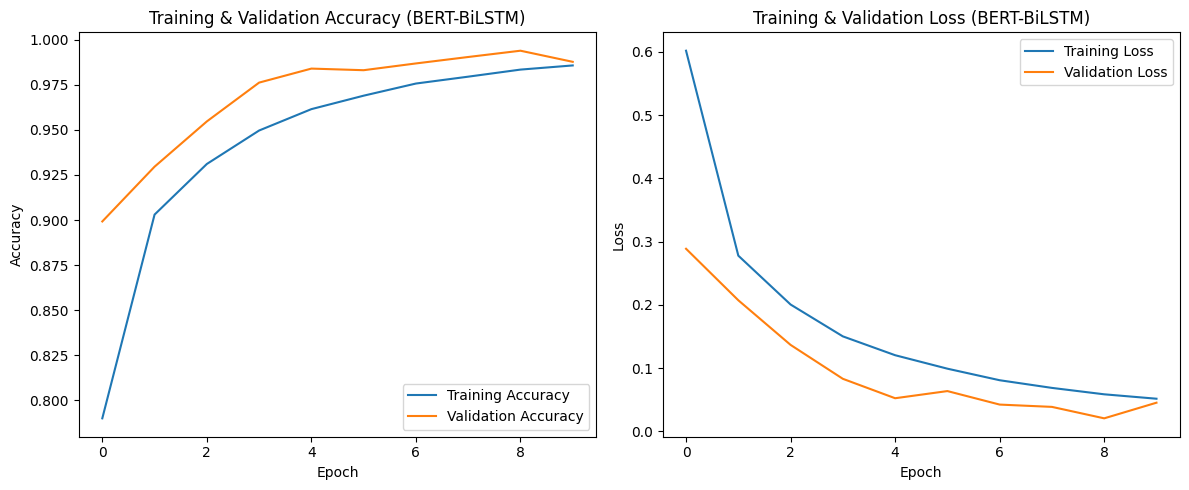

In [13]:
# Training Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy (BERT-BiLSTM)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss (BERT-BiLSTM)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [14]:
# Load Best Model
from transformers import TFBertModel
model = tf.keras.models.load_model(
    'hybrid_bert_bilstm.keras',
    custom_objects={'TFBertModel': TFBertModel},
    compile=True
)



Test loss and accuracy:
Loss: 0.0205
Accuracy: 0.9941 (99.41%)
1/1 [==============================] - 0s 344ms/step

Classification Report:
                      precision    recall  f1-score   support

             Anxiety     0.9993    0.9987    0.9990      1530
              Normal     0.9975    0.9956    0.9965      1588
          Depression     0.9826    0.9788    0.9807      1555
            Suicidal     0.9802    0.9836    0.9819      1463
              Stress     0.9986    1.0000    0.9993      1414
             Bipolar     0.9988    0.9988    0.9988      1651
Personality disorder     0.9985    1.0000    0.9993      2063

            accuracy                         0.9940     11264
           macro avg     0.9937    0.9936    0.9936     11264
        weighted avg     0.9940    0.9940    0.9940     11264



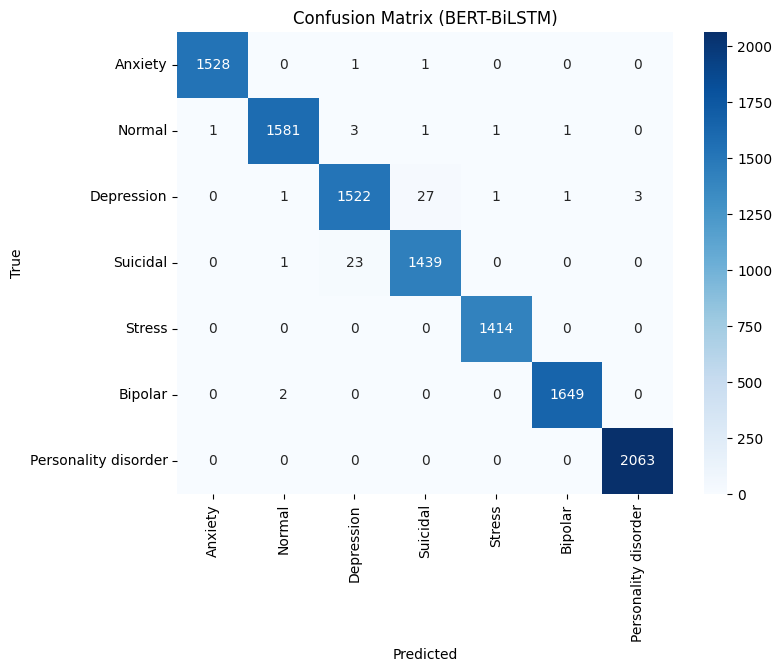

In [15]:
# Evaluation 
print("\nTest loss and accuracy:")
loss, accuracy = model.evaluate(test_ds, verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f} ({accuracy * 100:.2f}%)")

statuses = ['Anxiety','Normal','Depression','Suicidal','Stress','Bipolar','Personality disorder']
y_true, y_pred, y_pred_probs = [], [], []
for batch in test_ds:
    inputs, labels_onehot = batch
    probs = model.predict(inputs)
    preds = np.argmax(probs, axis=1)
    truths = np.argmax(labels_onehot.numpy(), axis=1)
    y_pred_probs.extend(probs)
    y_pred.extend(preds)
    y_true.extend(truths)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_probs = np.vstack(y_pred_probs)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=statuses, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=statuses, yticklabels=statuses)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (BERT-BiLSTM)')
plt.show()

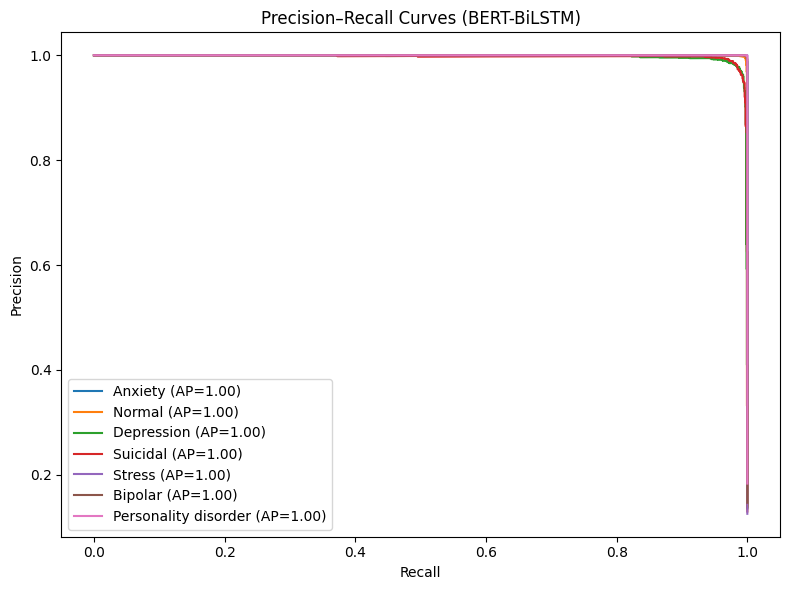

In [16]:
# Binarize for multi-class curves
n_classes = len(statuses)
y_true_binarized = label_binarize(y_true, classes=range(n_classes))

# Precision-Recall Curves
plt.figure(figsize=(8, 6))
for i, cls in enumerate(statuses):
    prec, rec, _ = precision_recall_curve(
        y_true_binarized[:, i], y_pred_probs[:, i]
    )
    ap = average_precision_score(
        y_true_binarized[:, i], y_pred_probs[:, i]
    )
    plt.plot(rec, prec, label=f'{cls} (AP={ap:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curves (BERT-BiLSTM)')
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()


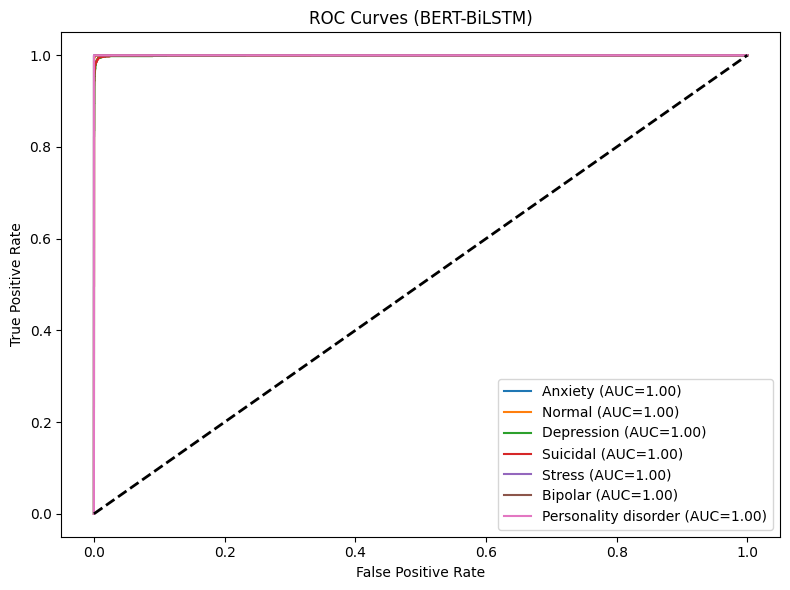

In [17]:
# ROC Curves
plt.figure(figsize=(8, 6))
for i, cls in enumerate(statuses):
    fpr, tpr, _ = roc_curve(
        y_true_binarized[:, i], y_pred_probs[:, i]
    )
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{cls} (AUC={roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (BERT-BiLSTM)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
